In [1]:
'''Going to see how the reweighting from the paper changes my results. 
I am generating a histogram but then accounting for the difference between probability and score. 
I am also using a re-weighting approximation '''



'Going to see how the reweighting from the paper changes my results. \nI am generating a histogram but then accounting for the difference between probability and score. \nI am also using a re-weighting approximation '

In [2]:
# import modules

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

import torch
#tf.enable_eager_execution()
%matplotlib inline

import sys
#sys.path.insert(1, '/Users/trentonbricken/protein-gen/pytorch/deep_boltzmann')

#from PlottingFunctions import *

import os
os.chdir('../pytorch')

from EVCouplingsGen import *
from evcouplings.couplings import CouplingsModel
from EVCouplingsStuff.seq_sele import *

from metropolis import MetropolisHastings
from utils import *

from nflib.MADE import *
from nflib.flows import *
from nflib.spline_flows import NSF_AR, NSF_CL
import itertools

import seaborn as sns
import matplotlib.pylab as plt

from evcouplings.couplings import CouplingsModel
from EVCouplingsStuff.seq_sele import *

from EVCouplingsGen import *

focus_seqs = read_fa('EVCouplingsStuff/DYR_ECOLI_1_b0.5.a2m_trimmed.fa')
evc_model = CouplingsModel('EVCouplingsStuff/DYR.model')
scores = evc_model.hamiltonians(list(focus_seqs['seq']))

In [32]:
# inverse sigmoid

def sigmoid(x):
    return 1/(1 + np.exp(-x)) 

def inv_sigmoid(x):
    return np.log(x/(1-x))

res = sigmoid(5)
org = inv_sigmoid(res)
print(res, org)

0.9933071490757153 5.000000000000019


In [3]:
# preprocessing: 

seq_len = 2
enc_seqs=[]
for seq in focus_seqs['seq']:
    enc_seqs.append(encode_aa(seq[:seq_len], evc_model.alphabet_map)) 

enc_seqs = np.asarray(enc_seqs)
target_seq = enc_seqs[0]#encode_aa(np.char.upper(ali.matrix[0, :]), a2n)

oh = []
N=20 # none of these focus have gaps, else should be 21. 
for seq in enc_seqs:
    oh.append(onehot(seq,N))
oh=np.asarray(oh)

print('calculating weights and identities')
N = oh.shape[0]
L = oh.shape[1]
AA = oh.shape[2]
w, neighbors = msa_weights(enc_seqs, theta=0.8, pseudocount=0)
oh.shape

h = evc_model.h_i[:seq_len,:]
print(h.shape)
        
J = evc_model.J_ij[:seq_len, :seq_len, :, :]
print(J.shape)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gen_model = EVCouplingsGenerator(L, AA, h, J, device, False, gaussian_cov_noise = 5.0)
#EVCouplingsGenerator(L, AA, h, J, device)

base = torch.distributions.multivariate_normal.MultivariateNormal(torch.zeros(gen_model.dim), torch.eye(gen_model.dim))

### the block mask setting is SUPER IMPORTANT!!!
flows = [AffineHalfFlow(dim=gen_model.dim, parity=i%2, nh=32 ,scale=False, block_mask=False) for i in range(4)]
flows.append(AffineConstantFlow(dim=gen_model.dim, shift=False))

network = NormalizingFlowModel(base, flows, gen_model)


calculating weights and identities
(2, 20)
(2, 2, 20, 20)
shape of feature map torch.Size([20, 3])


In [29]:
network.sample(50).shape

torch.Size([50, 6])

In [4]:
folder_name = 'continous_TrainLength_rand_seed-68_ML_epochs-3000_KL_epochs-2000_learning_rate-0.005_MLweight-1.0_KLweight-1.0_explore1.0_temperature-1.0_s_time-2020-03-02_23_30_44.780111'
#'continous_TEST_rand_seed-92_ML_epochs-300_KL_epochs-200_learning_rate-0.005_MLweight-1.0_KLweight-1.0_explore1.0_temperature-1.0_s_time-2020-03-02_23_20_49.028968'
#'continous_TEST_rand_seed-92_ML_epochs-300_KL_epochs-200_learning_rate-0.005_MLweight-1.0_KLweight-1.0_explore1.0_temperature-1.0_s_time-2020-03-02_23_20_49.028968'
#'NO_ENT_len2_NICE_diffMasks_maxOut_rand_seed-98_ML_epochs-80000_KL_epochs-80000_learning_rate-0.0005_MLweight-1.0_KLweight-1.0_explore1.0_temperature-1.0_s_time-2020-01-30_20_19_00.997518'
#'02_GPU_NICEvsNeuralS_len30_rand_seed-98_ML_epochs-8000_KL_epochs-15000_learning_rate-1e-05_MLweight-1.0_KLweight-1.0_explore1.0_temperature-1.0_s_time-2020-01-17_15_50_58.624611'
#'02_GPU_Analy_rand_seed-25_ML_epochs-1000_KL_epochs-1000_learning_rate-0.0001_MLweight-1.0_KLweight-1.0_explore1.0_temperature-1.0_s_time-2020-01-16_18_46_57.944733'
folder_name = folder_name.replace('/',':')
print(folder_name)
network.flow.load_state_dict(torch.load('experiments/'+folder_name+'/Model_Post_ML_Training.torch', map_location=device))



continous_TrainLength_rand_seed-68_ML_epochs-3000_KL_epochs-2000_learning_rate-0.005_MLweight-1.0_KLweight-1.0_explore1.0_temperature-1.0_s_time-2020-03-02_23_30_44.780111


<All keys matched successfully>

[[11  7]
 [ 2 12]
 [ 9 17]
 ...
 [16 16]
 [15  2]
 [15  9]] (5000, 2) <class 'numpy.ndarray'>


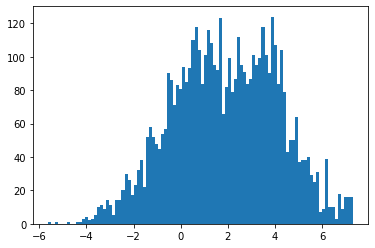

In [5]:
num_gen = 5000
exp_energy_x, hard_energy_x = network.sample_energy(temperature=1.0, num_samples=num_gen)
plt.hist(exp_energy_x, bins=100)
plt.show()

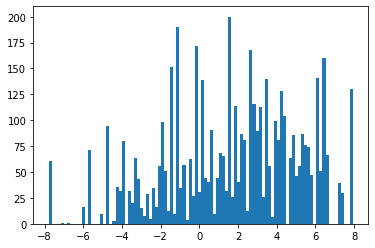

In [6]:
plt.hist(hard_energy_x, bins=100)
plt.show()

In [16]:
### checking for invertibility!!!!

inp = torch.tensor([np.eye(20)[:2,:]]*5).float()
print(inp.shape)
#encode sequences
inp = gen_model.encode(inp)
print(inp.shape)
inp = inp.reshape((inp.shape[0], -1))
# put through model
print(inp.shape, type(inp))
forw, _, _ = network.forward(inp)
# get back out
back,_,_ = network.backward(forw)

torch.Size([5, 2, 20])
torch.Size([5, 2, 3])
torch.Size([5, 6]) <class 'torch.Tensor'>


In [25]:
inp

tensor([[ 0.6200, 15.0000,  6.1100,  0.2900, 47.0000,  5.0200],
        [ 0.6200, 15.0000,  6.1100,  0.2900, 47.0000,  5.0200],
        [ 0.6200, 15.0000,  6.1100,  0.2900, 47.0000,  5.0200],
        [ 0.6200, 15.0000,  6.1100,  0.2900, 47.0000,  5.0200],
        [ 0.6200, 15.0000,  6.1100,  0.2900, 47.0000,  5.0200]])

In [26]:
forw

tensor([[-0.3801, -1.6256, -0.3648, -1.7463,  0.7119, -0.4219],
        [-0.3801, -1.6256, -0.3648, -1.7463,  0.7119, -0.4219],
        [-0.3801, -1.6256, -0.3648, -1.7463,  0.7119, -0.4219],
        [-0.3801, -1.6256, -0.3648, -1.7463,  0.7119, -0.4219],
        [-0.3801, -1.6256, -0.3648, -1.7463,  0.7119, -0.4219]],
       grad_fn=<AddBackward0>)

In [27]:
back

tensor([[ 0.6200, 15.0000,  6.1100,  0.2900, 47.0000,  5.0200],
        [ 0.6200, 15.0000,  6.1100,  0.2900, 47.0000,  5.0200],
        [ 0.6200, 15.0000,  6.1100,  0.2900, 47.0000,  5.0200],
        [ 0.6200, 15.0000,  6.1100,  0.2900, 47.0000,  5.0200],
        [ 0.6200, 15.0000,  6.1100,  0.2900, 47.0000,  5.0200]],
       grad_fn=<CopySlices>)

In [ ]:
def hard_max(inp):
    if inp.shape[1] > L: # if it isnt a sequence of ints, then all to one hot.  
        #print('the input to oh is', inp)

        if len(inp)>2:
            inp = inp.reshape(inp.shape[0], -1, 20)
        else:
            inp = inp.reshape(-1,20)

        inp = np.argmax(inp, axis=-1)
    return inp

def seq_counter(seqs, AA=20):
    # assumes not in one hot
    counter = np.zeros((AA, AA))
    for s in seqs: 
        counter[s[0], s[1]] +=1
    return counter

In [ ]:
x.shape

In [ ]:
# going to try and plot the energy rather than the probabilities
# this is more tricky because here I am not dealing with positions that I can bin by but rather whole sequences. 
# each sequence should be its own discrete bin? 

sample_x = network.sample(temperature=1.0, num_samples=num_gen).detach().numpy()

is_discrete = False

if not is_discrete: 
    inp = sample_x.reshape( sample_x.shape[0], gen_model.L, -1 )
    sample_x_seqs = gen_model.decode( torch.tensor(inp).float() ).numpy()
    x = sample_x_seqs.argmax(axis=-1)
    
    #gen_model.decode(torch.tensor(sample_x).float())
else:
    x = hard_max(sample_x_seqs)
# reversing energy here
sample_energies = -gen_model.energy(sample_x)


print('sample x shape', sample_x.shape, 'hard max', x.shape)
counter = seq_counter(x)

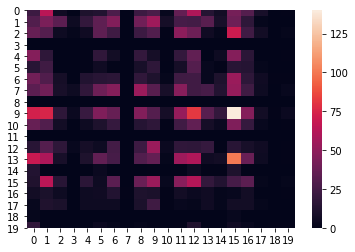

In [88]:
# check that the counter is working
import seaborn as sns;
sns.heatmap(counter.T)

/Users/trentonbricken/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


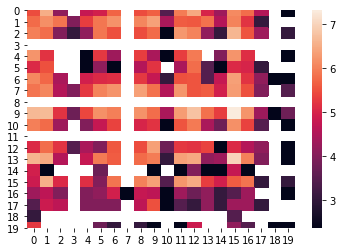

In [89]:
noe_scoring = -np.log(counter)
isinf = np.isinf(noe_scoring)
noe_scoring = noe_scoring - noe_scoring.min() + sample_energies.min()
noe_scoring[isinf] = None
sns.heatmap(-noe_scoring.T)

## now trying to run the reweighting code

In [90]:
def hist_weights(network):
    sample_x, log_w = network.sample_log_w(temperature=1.0, num_samples=100000)
    log_w -= log_w.max()
    bins = np.linspace(-2.5, 2.5, 100)
    bin_means = (bins[:-1] + bins[1:]) /2
    sample_x_index = np.digitize(sample_x[:, 0], bins)
    whist = np.zeros(len(bins) + 1)
    for i in range(len(log_w)):
        whist[sample_x_index[i]] += np.exp(log_w[i])
    return bin_means, whist[1:-1]

In [93]:
# reweights for the discrete sequences: 
sample_x, log_w = network.sample_log_w(temperature=1.0, num_samples=100000)
if not is_discrete: 
    inp = sample_x.reshape( sample_x.shape[0], gen_model.L, -1 )
    sample_x_seqs = gen_model.decode( torch.tensor(inp).float() ).numpy()
    x = sample_x_seqs.argmax(axis=-1)
else: 
    x = hard_max(sample_x)

log_w -= log_w.max()

counter = seq_counter(x)

# account for how much weight in total is in each bin. 
whist = np.zeros_like(counter)
for i in range(len(log_w)):
    whist[x[i][0], x[i][1]] += np.exp(log_w[i] - log_w.max())
 

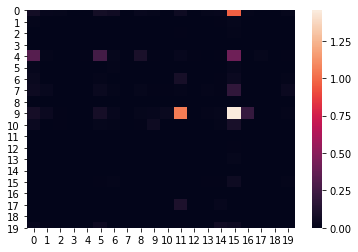

In [94]:
sns.heatmap(whist.T)

In [95]:
# now using the weights I need to resample the sequences. 
# get probabilities and then convert these back to scores. 

single_index_dict = dict()
for i in range(counter.shape[0] * counter.shape[1]):
    single_index_dict[i] = np.array( [i//counter.shape[0], i%counter.shape[1]])

#test_sample_rew(network, gen_model, temperature=1.0, plot=False)
single_index_dict;

In [96]:
whist.sum()

7.449174032992818

In [97]:
whist = whist/whist.sum()

In [98]:
n_boots = 10
energies = []
for n in range(n_boots):
    rand_inds = np.random.choice( np.arange(len(single_index_dict)), size =x.shape[0], p = whist.flatten(), replace=True )
    rand_seqs = []
    for r in rand_inds:
        rand_seqs.append(single_index_dict[r])
    rand_seqs = np.asarray(rand_seqs)
    rand_counter = seq_counter(rand_seqs)
    rand_counter = rand_counter / rand_counter.sum()
    E = -np.log(rand_counter)
    energies.append(E)
energies = np.asarray(energies)

/Users/trentonbricken/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()


In [99]:
np.mean( np.array([np.nan, 5, 6]))

nan

In [100]:
# compute the mean and std! 
emean = energies.mean(axis=0)
estd = energies.std(axis=0)
emean[ np.invert(np.isfinite(emean)) ] = np.nan
estd[ np.invert(np.isfinite(estd)) ] = np.nan

/Users/trentonbricken/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:193: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


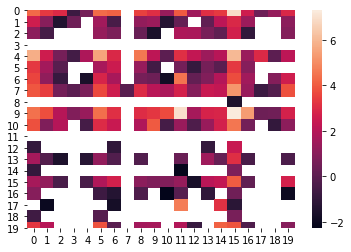

In [101]:
# plotting the energies after reweighted bootstrapping
emean = emean - emean[np.isfinite(emean)].min() + sample_energies.min()
sns.heatmap(-emean.T)

In [105]:
emean.shape

(20, 20)

In [117]:
top = -emean.flatten()
top = top[np.isfinite(top)].flatten()
top

array([ 4.30950968e+00,  2.60802541e+00,  1.14007479e+00,  5.80379794e+00,
        3.32571666e+00,  3.58690860e+00,  3.93313031e+00,  4.43485487e+00,
        3.79594294e+00, -9.35152105e-01,  1.64704018e+00, -9.68044169e-01,
        1.66897641e+00,  9.71118452e-01, -6.68470942e-01,  3.28126218e+00,
        3.31199109e+00,  1.02471445e+00, -5.25759306e-01,  2.58702749e+00,
        1.62305710e+00,  1.19932906e+00,  3.43840035e+00,  3.78613553e+00,
        8.35220788e-01, -2.00443176e-01,  1.24470791e+00, -1.96972579e+00,
        2.04108156e+00,  3.00697509e+00, -1.42290415e+00,  5.84548606e-01,
       -6.24064019e-02, -8.59187974e-01,  5.67416919e-01,  2.05733281e+00,
        1.98230185e+00, -1.51974483e+00, -4.00383060e-01, -7.31664392e-01,
        4.41588268e-01, -5.47778590e-01, -2.56536240e-03,  8.66785763e-01,
        5.90185235e-01,  1.82441881e+00, -1.61261615e+00,  7.08727481e-01,
        1.38677195e+00, -5.34895676e-01, -1.28303246e+00, -4.30208162e-01,
        4.34704826e+00,  

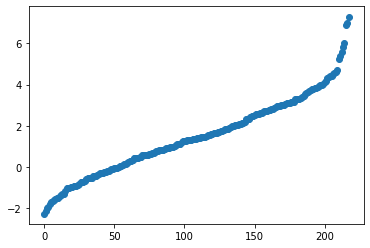

In [118]:
plt.scatter(np.arange(len(top)), np.sort(top) )
plt.show()

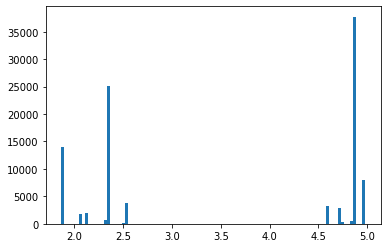

In [119]:
# plotting probabilities of one of the reweighted bootstraps
plt.hist(gen_model.energy(rand_seqs), bins=100)
plt.show()